# Analysis of vasopressor courses in MIMICIV
- Ruoyi Jiang

- To pull data... https://physionet.org/content/mimiciv/0.4/
- cd to base_dir to pull and set up


In [869]:
library(tidyverse)
library(fasttime)
library(epitools)
library(lme4)
library(pROC)
library(randomForest)
library(car)

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



In [870]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-apple-darwin18.5.0 (64-bit)
Running under: macOS Mojave 10.14.3

Matrix products: default
BLAS/LAPACK: /usr/local/Cellar/openblas/0.3.6_1/lib/libopenblasp-r0.3.6.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] car_3.0-3           carData_3.0-2       randomForest_4.6-14
 [4] pROC_1.15.3         lme4_1.1-21         Matrix_1.2-17      
 [7] epitools_0.5-10     fasttime_1.0-2      forcats_0.4.0      
[10] stringr_1.4.0       dplyr_0.8.1         purrr_0.3.3        
[13] readr_1.3.1         tidyr_0.8.3         tibble_2.1.1       
[16] ggplot2_3.2.0       tidyverse_1.2.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1        lubridate_1.7.4   lattice_0.20-38   assertthat_0.2.1 
 [5] zeallot_0.1.0     digest_0.6.18     IRdisplay_0.7.0   R6_2.4.0         
 [9] cellranger_1.

# Definitions

In [729]:
# base theme for plots
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

In [785]:
# roc curve plotting
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    base_theme() +
    theme(axis.title=element_text(size=10)) +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

In [730]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [731]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine", "Vasopressin", "Epinephrine")

In [732]:
FANCY_PRESSOR_DICT <- c(
'Dopamine' = 'Dopamine',
'Norepinephrine' = 'Norepinephrine',  
'Phenylephrine' = 'Phenylephrine',
"Vasopressin" = "Vasopressin",
"Epinephrine" = "Epinephrine"
)

In [772]:
FANCY_VITAL_ORDER <- c('MAP (mmHg)', 'HR (beats/min)', 'RR (breaths/min)', 'SpO2 (%)', 'Temperature (C)')

In [773]:
FANCY_VITAL_DICT <- c(
    'MBP' = 'MAP (mmHg)', 
    'HR' = 'HR (beats/min)', 
    'RR' = 'RR (breaths/min)', 
    'SPO2' = 'SpO2 (%)', 
    'TEMPC' = 'Temperature (C)')

In [774]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [782]:
odds_map <- read.csv(file.path(base_dir, "odds_map.csv"))

In [783]:
REF_COLORS = c(
'Significant' = "#2F4F4F",
'Not Significant' = "#D3D3D3",
'Reference' = "#000000"
)

In [728]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v3"

In [1]:
base_dir <- '~/Projects/Haimovich_Pressors/collection/mimic_4'

In [2]:
icu_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/icu")

In [3]:
core_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/core")

In [4]:
hosp_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/hosp")

### Vitals extraction

In [736]:
# Takes 1 hr to run, >16Gb RAM needed

# base_dir <- '~/Projects/Haimovich_Pressors/collection/mimic_4'
# df <- read_csv(file.path(icu_dir, 'chartevents.csv.gz'))
# # Join and output
# vitals_df <- df %>%
# 	select(subject_id, hadm_id, stay_id, charttime, valuenum, valueuom, itemid) %>%
# 	left_join(read.csv(file.path(base_dir, "mimic_vitals_map.csv")) %>% select(itemid, assignment)) %>% 
# 	drop_na(assignment) 
# vitals_df %>% write_csv(file.path(base_dir, 'vitals.csv.gz'))

# Extraction

In [8]:
patient_df <- read_csv(file.path(core_dir, "patients.csv.gz")) %>%
    select(subject_id, anchor_age, gender)

Parsed with column specification:
cols(
  subject_id = col_double(),
  gender = col_character(),
  anchor_age = col_double(),
  anchor_year = col_double(),
  anchor_year_group = col_character(),
  dod = col_logical()
)


In [99]:
death_df <- read_csv(file.path(core_dir, "admissions.csv.gz")) %>%
    select(subject_id, hadm_id, deathtime)

Parsed with column specification:
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  admittime = col_datetime(format = ""),
  dischtime = col_datetime(format = ""),
  deathtime = col_datetime(format = ""),
  admission_type = col_character(),
  admission_location = col_character(),
  discharge_location = col_character(),
  insurance = col_character(),
  language = col_character(),
  marital_status = col_character(),
  ethnicity = col_character(),
  edregtime = col_datetime(format = ""),
  edouttime = col_datetime(format = ""),
  hospital_expire_flag = col_double()
)


In [9]:
icustays_df <- read_csv(file.path(icu_dir, "icustays.csv.gz")) %>%
    select(subject_id, hadm_id, stay_id, first_careunit, intime, outtime, los)

Parsed with column specification:
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  stay_id = col_double(),
  first_careunit = col_character(),
  last_careunit = col_character(),
  intime = col_datetime(format = ""),
  outtime = col_datetime(format = ""),
  los = col_double()
)


In [11]:
ditems_df <- read_csv(file.path(icu_dir, "d_items.csv.gz"))

Parsed with column specification:
cols(
  itemid = col_double(),
  label = col_character(),
  abbreviation = col_character(),
  linksto = col_character(),
  category = col_character(),
  unitname = col_character(),
  param_type = col_character(),
  lownormalvalue = col_double(),
  highnormalvalue = col_double()
)


In [20]:
vasopressor_list <- list()
for(vasopressor_choice in FANCY_PRESSOR_ORDER){
    vasopressor_list[[vasopressor_choice]] <- ditems_df %>% 
        filter(grepl(vasopressor_choice, label)) %>%
        mutate(vasopressor = vasopressor_choice)
}
vasopressor_choices_df <- bind_rows(vasopressor_list)  %>%
    filter(param_type == "Solution") %>%
    select(itemid, vasopressor)

In [10]:
input_df <- read_csv(file.path(icu_dir, "inputevents.csv.gz")) 
# subject id, stay_id, start/end time for order
# 8 million lines

Parsed with column specification:
cols(
  .default = col_double(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  storetime = col_datetime(format = ""),
  amountuom = col_character(),
  rateuom = col_character(),
  ordercategoryname = col_character(),
  secondaryordercategoryname = col_character(),
  ordercomponenttypedescription = col_character(),
  ordercategorydescription = col_character(),
  totalamountuom = col_character(),
  statusdescription = col_character()
)
See spec(...) for full column specifications.


In [102]:
inputmed_df <- input_df %>%
    select(subject_id, hadm_id, stay_id, starttime, endtime, itemid) %>%
    left_join(vasopressor_choices_df) %>%
    filter(!is.na(vasopressor)) %>%
    mutate(duration_hours = difftime(endtime, starttime, units="hours")) %>%

Joining, by = "itemid"


In [ ]:
inputmed_df %>%
    filter((vasopressor == 'Phenylephrine' & duration_hours > 0.5) |
           (vasopressor == 'Epinephrine' & duration_hours > 0.5) |
           !(vasopressor %in% c('Phenylephrine', 'Epinephrine'))
          ) %>%

In [25]:
procedure_df <- read_csv(file.path(icu_dir, "procedureevents.csv.gz"))

Parsed with column specification:
cols(
  .default = col_double(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  storetime = col_datetime(format = ""),
  valueuom = col_character(),
  location = col_character(),
  locationcategory = col_character(),
  ordercategoryname = col_character(),
  secondaryordercategoryname = col_logical(),
  ordercategorydescription = col_character(),
  totalamount = col_logical(),
  totalamountuom = col_logical(),
  statusdescription = col_character(),
  comments_date = col_logical()
)
See spec(...) for full column specifications.


In [259]:
cvc_items <- c(
'224263', #-- Multi Lumen
'224264', #-- PICC Line
'224267', #-- Cordis/Introducer
'224268', #-- Trauma line
'225199', #-- Triple Introducer
'225202', #-- Indwelling Port (PortaCath)
'225203', #-- Pheresis Catheter
'225315', #-- Tunneled (Hickman) Line
'227719', #-- AVA Line
'224270' #-- Dialysis Catheter
)

In [260]:
# caution multiple lines
cvc_df <- procedure_df %>%
    filter(itemid %in% cvc_items) %>%
    mutate(cvc = TRUE) %>%
    select(subject_id, hadm_id, stay_id, cvc, starttime, endtime) %>%
    distinct() %>%
    rename(cvc_starttime = starttime, cvc_endtime = endtime)

In [53]:
intubated_df <- procedure_df %>% 
    filter(grepl("Ventilation|Intubation/Extubation", ordercategoryname)) %>% 
    mutate(intubated = TRUE) %>%
    select(subject_id, hadm_id, stay_id, intubated) %>%
    distinct()

In [75]:
infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS',
                    'SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [65]:
drg_df <- read.csv(file.path(hosp_dir, 'drgcodes.csv.gz'))

In [69]:
drg_df <- drg_df %>%
    mutate(description = toupper(description))

In [72]:
drg_df  <- drg_df %>%
    group_by(hadm_id, subject_id) %>%
    summarize(description = paste(description, collapse=";"))

In [76]:
# 1 min
drg_df <- drg_df %>%
    mutate(diagnosis = simplifyDiagnosis(description))

In [325]:
drg_df %>%
    group_by(diagnosis) %>%
    summarize(COUNT = n())

diagnosis,COUNT
<chr>,<int>
CARDIAC,19692
INFECTION,35630
OTHER DIAGNOSIS,274250


# Combine

In [121]:
inputmed_df <- inputmed_df %>% 
    filter((vasopressor == 'Phenylephrine' & as.numeric(duration_hours) > 0.5) |
           (vasopressor == 'Epinephrine' & as.numeric(duration_hours) > 0.5) |
           !(vasopressor %in% c('Phenylephrine', 'Epinephrine'))
          )

In [187]:
max_intervening_hrs <- 24

input_courses_df <- inputmed_df %>%
        group_by(subject_id,hadm_id,stay_id) %>%
        arrange(starttime) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(subject_id,hadm_id,stay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [385]:
courses_df <- input_courses_df

In [386]:
courses_df <- courses_df %>%
    left_join(icustays_df)

Joining, by = c("subject_id", "hadm_id", "stay_id")


In [387]:
courses_df <- courses_df %>%
    left_join(death_df)

Joining, by = c("subject_id", "hadm_id")


In [388]:
courses_df <- courses_df %>%
    left_join(patient_df)

Joining, by = "subject_id"


In [389]:
courses_df <- courses_df %>%
    left_join(intubated_df) %>%
    replace_na(list(intubated=FALSE))

Joining, by = c("subject_id", "hadm_id", "stay_id")


In [390]:
courses_df <- courses_df %>%
    left_join(drg_df) %>% filter(!is.na(diagnosis))

Joining, by = c("subject_id", "hadm_id")


# Filters

In [392]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id, continuous_course) %>%
    mutate(course_starttime = min(starttime)) %>%
    mutate(course_endtime = max(endtime)) %>%
    group_by(subject_id,hadm_id,stay_id) %>%
    mutate(FIRSTCOURSE = min(course_starttime) == course_starttime)

In [393]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id) %>%
    mutate(LESS1HOUR = difftime(min(course_starttime), 
                         min(intime)) < 1)

In [394]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, course_endtime, units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [395]:
courses_df <- courses_df %>%
    mutate(TOOYOUNG = anchor_age >= 18 | is.na(anchor_age))

In [396]:
courses_df <- courses_df %>%
    mutate(ICUSTAY = grepl("ICU", first_careunit))

In [397]:
courses_df %>% 
    group_by(FIRSTCOURSE) %>%
    summarize(COUNT = n())

FIRSTCOURSE,COUNT
<lgl>,<int>
FALSE,74349
TRUE,411216


In [398]:
courses_df %>% 
    group_by(LESS1HOUR) %>%
    summarize(COUNT = n())

LESS1HOUR,COUNT
<lgl>,<int>
FALSE,465080
TRUE,20485


In [399]:
courses_df %>% 
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,483347
TRUE,2218


In [400]:
courses_df %>% 
    group_by(TOOYOUNG) %>%
    summarize(COUNT = n())

TOOYOUNG,COUNT
<lgl>,<int>
TRUE,485565


In [401]:
courses_df %>% 
    group_by(ICUSTAY) %>%
    summarize(COUNT = n())

ICUSTAY,COUNT
<lgl>,<int>
FALSE,57491
TRUE,428074


In [402]:
courses_df <- courses_df %>%
    filter(FIRSTCOURSE, !LESS1HOUR, !STOPMORTALITY, TOOYOUNG, ICUSTAY)

In [403]:
dim(courses_df)

[1] 345718     27

### Collapse into courses

In [405]:
# collapse so each row is a course_id
output_df <- courses_df %>%
    ungroup() %>%
    mutate(course_id = paste(stay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    summarize(
            PATIENT = unique(subject_id)[1],
            diagnosis = unique(diagnosis)[1], 
            age = unique(anchor_age)[1], 
            intubated = unique(intubated)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            stay_id = unique(stay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime),
            vasopressor = paste(unique(vasopressor), collapse=",")
    ) %>% 
    mutate(duration_hours = difftime(endtime, 
                       starttime, units="hours"))

In [406]:
output_df <- output_df %>%
    mutate(age_cohort = as.numeric(round(age, digits = -1))) 

In [407]:
cvc_used_df <- output_df  %>%
    left_join(cvc_df) %>% 
    mutate(cvc_used = !is.na(cvc) & (endtime > cvc_starttime | starttime < cvc_endtime)) %>%
    group_by(course_id) %>%
    summarize(cvc = any(cvc_used))

output_df <- output_df %>%
    left_join(cvc_used_df)

Joining, by = "stay_id"
Joining, by = "course_id"


In [408]:
output_df <- output_df %>%
    rowwise() %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               ) %>%
    mutate(RESPONSE = MORETHAN24HOURS | grepl(",", vasopressor))

In [409]:
output_df <- output_df %>%
    rename(
        pressor = vasopressor, 
        duration = duration_hours, 
        simple_diagnosis = diagnosis,
        intub=intubated)

In [410]:
output_df <- ungroup(output_df)

# Summary Stats

In [411]:
dim(output_df)

[1] 17142    17

In [412]:
length(unique(output_df$PATIENT))

[1] 15115

In [413]:
length(unique(output_df$stay_id))

[1] 17142

In [414]:
length(unique(output_df$course_id))

[1] 17142

In [415]:
min(output_df$age, na.rm=TRUE)

[1] 18

In [416]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>%
    filter(!grepl(",", pressor))

STATUS,pressor,COUNT
<chr>,<chr>,<int>
LESSTHAN24HOURS,Dopamine,74
LESSTHAN24HOURS,Epinephrine,108
LESSTHAN24HOURS,Norepinephrine,1498
LESSTHAN24HOURS,Phenylephrine,2382
LESSTHAN24HOURS,Vasopressin,6
LESSTHAN6HOURS,Dopamine,80
LESSTHAN6HOURS,Epinephrine,74
LESSTHAN6HOURS,Norepinephrine,1128
LESSTHAN6HOURS,Phenylephrine,2486


In [874]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,13311,0.7765138
TRUE,3831,0.2234862


In [419]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,9157,0.534185
TRUE,7985,0.465815


In [420]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,11337,0.6613581
TRUE,5805,0.3386419


In [864]:
# Courses lasting more than 24 hours but without multiple pressor in which CVC was used
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,775,0.2022971
TRUE,TRUE,3056,0.7977029


In [421]:
# Courses lasting more than 24 hours but without multiple pressor in which CVC was used
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,1551,0.1942392
TRUE,TRUE,6434,0.8057608


In [865]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,324,0.09665871
TRUE,TRUE,3028,0.90334129


In [424]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,436,0.07510767
TRUE,TRUE,5369,0.92489233


In [422]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(cvc) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(cvc)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,TRUE,8056,0.5431866
TRUE,TRUE,6775,0.4568134


Warning message:
“Removed 969 rows containing non-finite values (stat_density).”

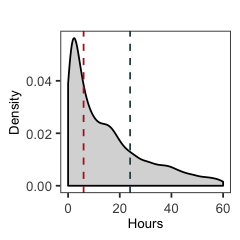

In [737]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [738]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 969 rows containing non-finite values (stat_density).”

pdf 
  2

Warning message:
“Removed 969 rows containing non-finite values (stat_density).”

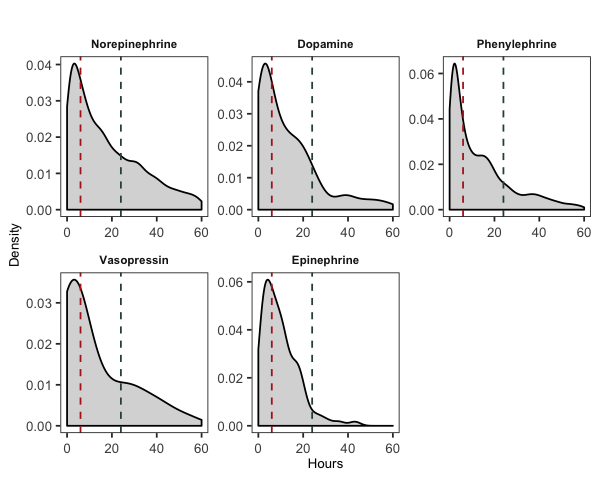

In [739]:
options(repr.plot.width=5, repr.plot.height=4)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_wrap(. ~fancy_pressor, nrow=2, ncol=3, scale = "free")
plot(p)

In [740]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 5, 4)
plot(p)
dev.off()

Warning message:
“Removed 969 rows containing non-finite values (stat_density).”

pdf 
  2

# CVC Use

In [429]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [430]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1100,21.621258 hours,0.1465494
FALSE,TRUE,6406,34.887327 hours,0.8534506
TRUE,FALSE,775,2.379656 hours,0.2022971
TRUE,TRUE,3056,2.496717 hours,0.7977029


In [431]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1805,0.18304432
FALSE,TRUE,8056,0.81695568
TRUE,FALSE,506,0.06949595
TRUE,TRUE,6775,0.93050405


In [432]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1875,0.16538767
FALSE,TRUE,9462,0.83461233
TRUE,FALSE,436,0.07510767
TRUE,TRUE,5369,0.92489233


In [433]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 2454 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2454 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2454 rows containing non-finite values (stat_summary).”

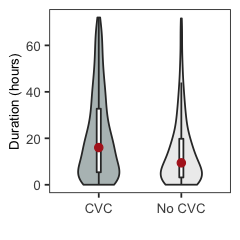

In [741]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [742]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 2454 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2454 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2454 rows containing non-finite values (stat_summary).”

pdf 
  2

In [436]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    print(pressor_choice)
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

[1] "Norepinephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 
[1] "Dopamine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE 0.0065

P value adjustment method: holm 
[1] "Phenylephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE  
TRUE 0.00031

P value adjustment method: holm 
[1] "Vasopressin"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.59 


Warning message:
“Removed 659 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 659 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 659 rows containing non-finite values (stat_summary).”

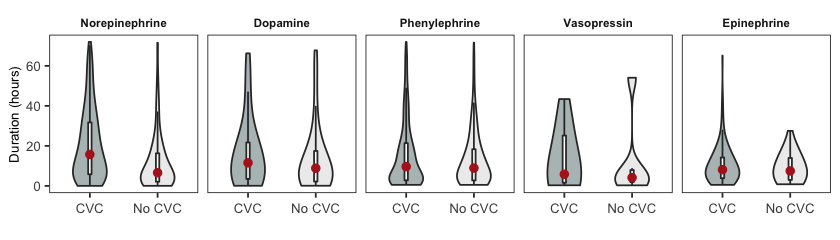

In [743]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [744]:
total_df <- output_df %>%
    summarize(
            TOTAL = "TOTAL",
            n = paste(round(as.numeric(n()),2)), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M')),
            MICU = paste(sum(first_careunit == 'Medical Intensive Care Unit (MICU)')),
            SICU = paste(sum(first_careunit == 'Surgical Intensive Care Unit (SICU)')),
            CCU = paste(sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)')),
            TSICU = paste(sum(first_careunit == 'Trauma SICU (TSICU)')),
            MSICU = paste(sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)')),
            NSICU = paste(sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)')),
            Infectious_Diagnosis = paste(sum(simple_diagnosis == "INFECTION")),
            Cardiac_Diagnosis = paste(sum(simple_diagnosis == "CARDIAC")),
            Other_Diagnosis = paste(sum(simple_diagnosis == "OTHER DIAGNOSIS")),
            Intubated = paste(sum(intub == "TRUE"))
             ) %>% t()

In [745]:
output_df %>%
    group_by(simple_diagnosis) %>%
    summarize(COUNT = n())

simple_diagnosis,COUNT
<chr>,<int>
CARDIAC,3076
INFECTION,2961
OTHER DIAGNOSIS,11105


In [746]:
colnames(total_df) <- "TOTAL"

In [747]:
total_df

,TOTAL
TOTAL,TOTAL
n,17142
Age,65.16 (SD=14.49)
Male,10412
MICU,3757
SICU,2191
CCU,6342
TSICU,2077
MSICU,2434
NSICU,341


In [748]:
sum_df <- output_df %>% 
    rowwise() %>%
    mutate(STATUS = if(grepl(",", pressor)){"MULTI"}else{STATUS}) %>%
    group_by(STATUS) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'Medical Intensive Care Unit (MICU)'),
            SICU = sum(first_careunit == 'Surgical Intensive Care Unit (SICU)'),
            CCU = sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)'),
            TSICU = sum(first_careunit == 'Trauma SICU (TSICU)'),
            MSICU =sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)'),
            NSICU = sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE")) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [749]:
sum_df

STATUS,n,Age,Male,MICU,SICU,CCU,TSICU,MSICU,NSICU,Infectious_Diagnosis,Cardiac_Diagnosis,Other_Diagnosis,Intubated
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LESSTHAN24HOURS,4154,64.68 (SD=14.2),2618,772,503,1692,484,604,99,643,920,2591,3053
LESSTHAN6HOURS,3831,66.03 (SD=14.23),2357,593,447,1899,375,456,61,450,985,2396,3041
MORETHAN24HOURS,3352,64.56 (SD=14.91),1914,937,515,788,497,540,75,722,414,2216,2483
MULTI,5805,65.29 (SD=14.59),3523,1455,726,1963,721,834,106,1146,757,3902,5100


In [750]:
t1_df <- sum_df %>%
    ungroup() %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        MSICU = paste(round(MSICU,2), paste0('(', 100*(MSICU/sum(MSICU)) %>% round(3), '%)')),
        NSICU = paste(round(NSICU,2), paste0('(', 100*(NSICU/sum(NSICU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)'))
    ) %>% t()

In [751]:
colnames(t1_df) <- t1_df[1,]

In [752]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
n,4154 (24.2%),3831 (22.3%),3352 (19.6%),5805 (33.9%)
Age,64.68 (SD=14.2),66.03 (SD=14.23),64.56 (SD=14.91),65.29 (SD=14.59)
Male,2618 (25.1%),2357 (22.6%),1914 (18.4%),3523 (33.8%)
MICU,772 (20.5%),593 (15.8%),937 (24.9%),1455 (38.7%)
SICU,503 (23%),447 (20.4%),515 (23.5%),726 (33.1%)
CCU,1692 (26.7%),1899 (29.9%),788 (12.4%),1963 (31%)
TSICU,484 (23.3%),375 (18.1%),497 (23.9%),721 (34.7%)
MSICU,604 (24.8%),456 (18.7%),540 (22.2%),834 (34.3%)
NSICU,99 (29%),61 (17.9%),75 (22%),106 (31.1%)


In [753]:
cbind(total_df,t1_df) %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

In [891]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'Medical Intensive Care Unit (MICU)'),
            SICU = sum(first_careunit == 'Surgical Intensive Care Unit (SICU)'),
            CCU = sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)'),
            TSICU = sum(first_careunit == 'Trauma SICU (TSICU)'),
            MSICU =sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)'),
            NSICU = sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE")) %>%
    ungroup() %>%
    group_by(pressor) %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        MSICU = paste(round(MSICU,2), paste0('(', 100*(MSICU/sum(MSICU)) %>% round(3), '%)')),
        NSICU = paste(round(NSICU,2), paste0('(', 100*(NSICU/sum(NSICU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)'))
    ) 

In [893]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    out_df <- s1_3_df %>%
        filter(pressor == pressor_choice) %>%
        ungroup() %>%
        t()
    colnames(out_df) <- out_df[1,]
    out_df %>% 
        data.frame() %>%
        select(LESSTHAN6HOURS, LESSTHAN24HOURS, MORETHAN24HOURS) %>%
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_demographics.csv")))
}

# Relative Risk

In [757]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(RESPONSE, gender) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(RESPONSE, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(RESPONSE, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, RESPONSE) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(RESPONSE, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, RESPONSE) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


#     # careunit
#     careunit_df <- df %>%
#         group_by(RESPONSE, first_careunit) %>%
#         summarize(COUNT = n())

#     rr_list <- list()
#     for(cu in unique(careunit_df$first_careunit)){
#        output <- careunit_df%>%
#             mutate(CU_BOOL = first_careunit == cu) %>%
#             group_by(CU_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("CU_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[cu]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
#     }

#     all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(RESPONSE, intub) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

#     # cvc
#     output <- df %>%
#         group_by(RESPONSE, cvc) %>%
#         summarize(COUNT = n()) %>%
#         spread(RESPONSE, COUNT) %>%
#         tibble::column_to_rownames("cvc") %>%
#         as.matrix() %>% riskratio()

#     all_rr_list[['CVC_RR']] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}

In [758]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9447074,0.9183703,0.9717997,MALE,9.461819e-05,TRUE
AGE_RR,0.9860656,0.8654345,1.1235112,20,8.330678e-01,FALSE
AGE_RR,1.1040226,1.0183266,1.1969303,30,2.660856e-02,TRUE
AGE_RR,1.0478752,0.9877674,1.1116407,40,1.361753e-01,FALSE
AGE_RR,1.0312853,0.9892054,1.0751552,50,1.535803e-01,FALSE
AGE_RR,0.9747556,0.9439778,1.0065369,60,1.185087e-01,FALSE
AGE_RR,0.9747702,0.9430119,1.0075980,70,1.285031e-01,FALSE
AGE_RR,0.9980484,0.9647657,1.0324792,80,9.113788e-01,FALSE
AGE_RR,1.0308210,0.9747581,1.0901083,90,2.983774e-01,FALSE


In [759]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

In [760]:
pressor_rr_list <- list()
for(pressor_choice in c('Norepinephrine', 'Dopamine', 'Phenylephrine')){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [761]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [762]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
Norepinephrine,MALE_RR,1.0135648,0.9869434,1.0409043,M,3.193985e-01,FALSE
Norepinephrine,AGE_RR,0.9409042,0.8298038,1.0668796,20,3.186610e-01,FALSE
Norepinephrine,AGE_RR,1.0429052,0.9710403,1.1200887,30,2.846623e-01,FALSE
Norepinephrine,AGE_RR,0.9916279,0.9387958,1.0474333,40,7.768759e-01,FALSE
Norepinephrine,AGE_RR,0.9901886,0.9527412,1.0291079,50,6.177881e-01,FALSE
Norepinephrine,AGE_RR,1.0057335,0.9761110,1.0362551,60,7.134036e-01,FALSE
Norepinephrine,AGE_RR,1.0045880,0.9737047,1.0364510,70,7.841615e-01,FALSE
Norepinephrine,AGE_RR,1.0148586,0.9832756,1.0474560,80,3.699072e-01,FALSE
Norepinephrine,AGE_RR,0.9514830,0.9005734,1.0052705,90,6.624126e-02,FALSE


In [763]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

In [764]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
#'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis" #,
# 'CCU' = 'CCU',
# 'CSRU' = 'CSRU',
# 'MICU' = 'MICU',
# 'SICU' = 'SICU',
# 'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

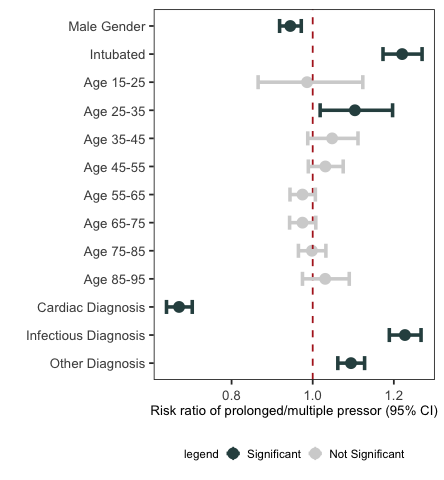

In [765]:
options(repr.plot.width=3.7, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [766]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.7,4)
plot(p)
dev.off()

pdf 
  2

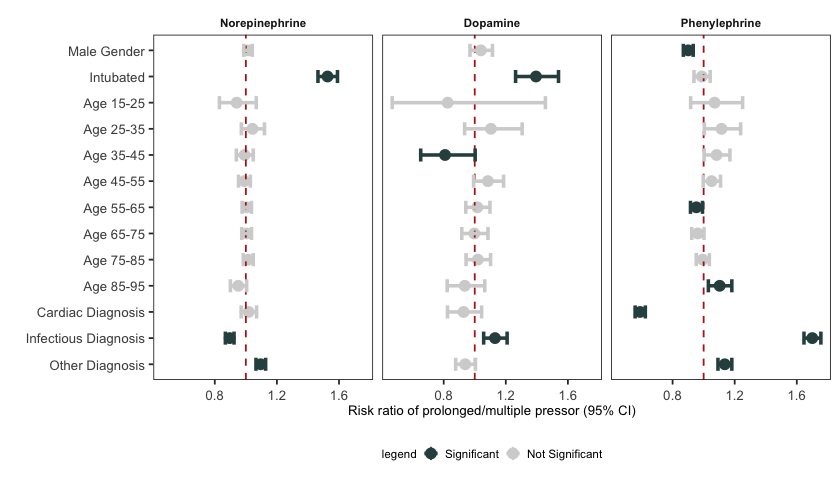

In [767]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [768]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

In [466]:
vitals_df <- read_csv(file.path(base_dir, 'vitals.csv.gz'))

Parsed with column specification:
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  stay_id = col_double(),
  charttime = col_datetime(format = ""),
  valuenum = col_double(),
  valueuom = col_character(),
  itemid = col_double(),
  assignment = col_character()
)


In [467]:
# 10 mins
vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(stay_id %in% output_df$stay_id) %>%
    left_join(select(output_df, stay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, RESPONSE, STATUS), by = "stay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [478]:
# for 10 hours prior to pressor initiation
intervals <- 1:10

In [484]:
results_list <- list()

In [485]:
# takes 40 mins to run overall
for(interval in intervals){
    # 4 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, RESPONSE, STATUS, course_id, pressor, assignment) %>%
        summarize(mean = mean(valuenum, na.rm=T)) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [486]:
melt_results_df <- bind_rows(results_list) 

In [487]:
#melt_results_df %>% write.csv(file.path(base_dir, 'melt_summarized_vitals_mimic4.csv'))

In [ ]:
#melt_results_df <- read.csv(file.path(base_dir, 'melt_summarized_vitals_mimic4.csv'))

In [495]:
melt_results_df <- melt_results_df %>%
    mutate(ID = assignment, VALUE = mean)

In [497]:
computeRandomEffects <- function(df){
    vitals_result_list <- list()
    for(vital in unique(df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        
        test <- lmer(VALUE ~ RESPONSE*INTERVAL + (1|course_id), data = totest) 
        ci <- confint(test, nsim=500)
        ce <- coef(summary(test))
        
        # The space is necessary
        vitals_result_list[[vital]] <- data.frame(INTERACTION = ce['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_LOWER = ci['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_UPPER = ci['RESPONSETRUE:INTERVAL',][2],
            RESPONSE =  ce["RESPONSETRUE",][1],
            RESPONSE_LOWER = ci["RESPONSETRUE",][1],
            RESPONSE_UPPER = ci["RESPONSETRUE",][2])
        
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
    
}

In [498]:
randomeffects_significance_df  <- computeRandomEffects(melt_results_df)

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
boundary (singular) fit: see ?isSingular
Computing profile confidence intervals ...
Computing profile confidence intervals ...


In [769]:
randomeffects_significance_df 

ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DBP,3.30330079,-2.34489381,8.95160064,-8.25265712,-37.1502548,20.64491636
HR,0.02735677,-0.48613265,0.54042757,5.52932282,2.8679241,8.19097479
MBP,0.15061608,-0.32789340,0.62901893,-1.60824294,-4.1756920,0.95912319
RR,0.11031857,0.04267681,0.17788904,1.52419722,1.0807159,1.96765115
SBP,0.07095166,-0.17267007,0.31453853,-2.74026217,-4.2907113,-1.18962939
SPO2,-0.09302176,-0.22845596,0.04250286,-0.71040579,-1.4058888,-0.01505882
TEMPF,0.15588169,-0.21537883,0.52714227,-0.09405595,-1.9320625,1.74395058
TEMPC,-0.01089300,-0.07197409,0.05012774,0.27253285,-0.6416951,1.18674782


In [770]:
randomeffects_significance_df  %>% write.csv(file.path(PLOT_DIR, "re_significance.csv"))

In [503]:
pressors_vitals_rr_list <- list()
for(pressor_choice in c("Norepinephrine", "Dopamine", "Phenylephrine")){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeRandomEffects()
}

pressors_vitals_randomeffects_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
boundary (singular) fit: see ?isSingular
Computing profile confidence intervals ...
Warning message in zeta(shiftpar, start = opt[seqpar1][-w]):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”Warning message in zetafun(np, ns):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”Warning message in zetafun(np, ns):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta valu

In [505]:
pressors_vitals_randomeffects_df %>% arrange(ID) 

pressor,ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Norepinephrine,DBP,5.930666024,-5.28585112,17.147425263,-15.62153491,-73.5363664,42.2936936
Dopamine,DBP,0.878801794,-0.24119652,1.982601257,2.56315714,-5.3655140,10.5008808
Phenylephrine,DBP,-1.540223771,-2.99762813,-0.082610821,3.72694176,-3.6684159,11.1216966
Norepinephrine,HR,-0.217467780,-0.45074364,0.015792150,6.67670739,4.2794864,9.0739117
Dopamine,HR,-0.130423113,-1.03936106,0.776691628,14.34528538,2.0646959,26.6239531
Phenylephrine,HR,-0.248136823,-1.02939637,0.531934234,7.45543207,3.4975291,11.4144738
Norepinephrine,MBP,0.122558457,-0.79884421,1.043616697,-0.69387418,-5.6766781,4.2897733
Dopamine,MBP,0.635187170,-0.57694909,1.826983768,2.92783332,-5.5905785,11.4561202
Phenylephrine,MBP,0.044037477,-0.20259568,0.290664228,-1.94214317,-3.4495064,-0.4344073


In [771]:
pressors_vitals_randomeffects_df %>% write.csv(file.path(PLOT_DIR, "re_significance_eachpressor.csv"))

### Plotting vitals

In [775]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(ID != "DBP", ID != "SBP", ID != 'TEMPF')

In [776]:
# 3-5 mins
toplot <- toplot %>%
    rowwise() %>%
    mutate(ID = as.character(ID)) %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

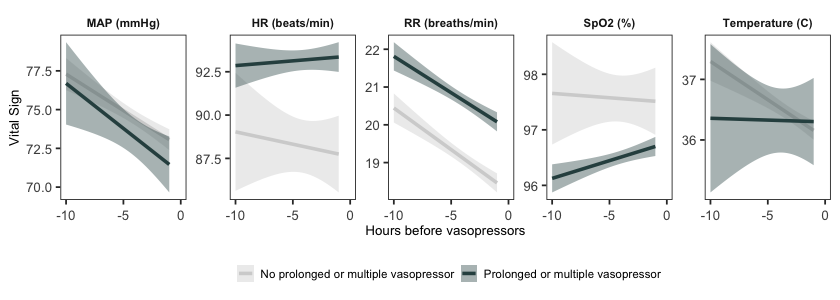

In [777]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [778]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

pdf 
  2

Warning message in qt((1 - level)/2, df):
“NaNs produced”Warning message in qt((1 - level)/2, df):
“NaNs produced”

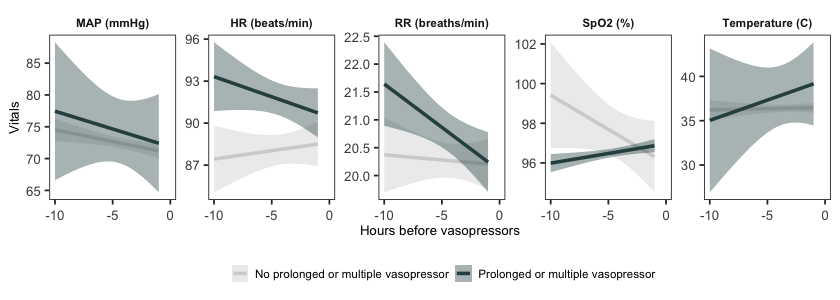

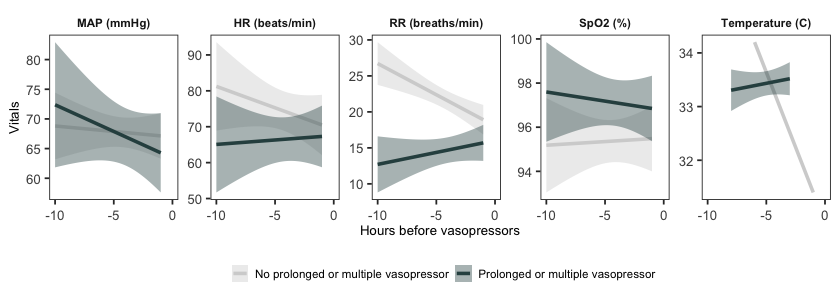

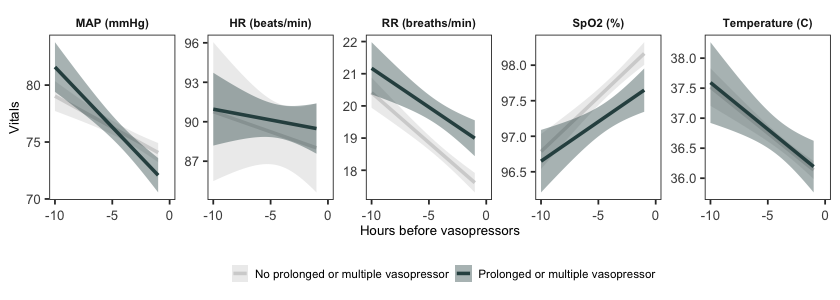

In [863]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in c("Norepinephrine", "Dopamine", "Phenylephrine")){
    toplot <- melt_results_df %>%
        filter(!grepl(",", pressor)) %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, ID != "DBP", ID != "SBP", ID != 'TEMPF') %>%
        rowwise() %>%
        mutate(ID = as.character(ID)) %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# MLR analysis

In [780]:
set.seed(100)

In [781]:
lr_summary_list <- list()

## Total

In [786]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR), 
           SPO2 = as.numeric(SPO2))

# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

Adding missing grouping variables: `pressor`


In [787]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.946184  5        1.068854
intub            1.220595  1        1.104805
simple_diagnosis 1.663497  2        1.135679
age_cohort       1.057899  1        1.028542
gender           1.030130  1        1.014953
MBP              1.021579  1        1.010732
RR               1.256141  1        1.120777
HR               1.192636  1        1.092079
SPO2             1.133674  1        1.064741


Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [788]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[['TOTAL']] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6688474,0.01376877,0.6195833,0.01957668


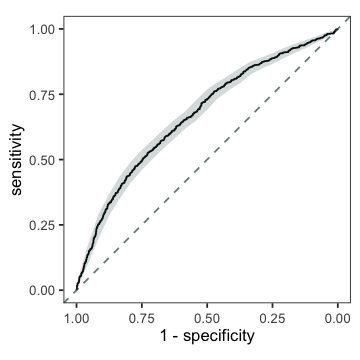

In [789]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [790]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [791]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% select(-MBP, -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.249   100.05 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2584   103.84 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2544   102.26 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2619   105.25 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2574   103.44 |


In [792]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [793]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [794]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...


In [795]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"


In [797]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0("categoricalmodeleodds.csv")))

In [866]:
read.csv(file.path(PLOT_DIR, paste0("categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,1.3370545,1.1958381,1.4949085,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,1.0289241,0.9101516,1.1632008,FALSE,Not Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,0.8951289,0.7095310,1.1302000,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0699961,0.9457621,1.2106263,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,0.6405638,0.5743595,0.7142168,TRUE,Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,2.2097562,2.0333801,2.4021178,TRUE,Significant
8,Categorical,Intubation,,Variable,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,Diagnosis,simple_diagnosisINFECTION,Variable,Infection,1.3950119,1.2689586,1.5342012,TRUE,Significant


In [798]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0("continuousmodeleodds.csv")))

In [867]:
read.csv(file.path(PLOT_DIR, paste0("continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Continuous,Vitals,MBP,Variable,MAP,0.9966777,0.9936885,0.9996721,TRUE,Significant
2,Continuous,Vitals,HR,Variable,HR,1.0068745,1.0044751,1.0092883,TRUE,Significant
3,Continuous,Vitals,RR,Variable,RR,1.0014839,0.9973059,1.0056833,FALSE,Not Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.9955074,0.9933132,0.9977013,TRUE,Significant
5,Continuous,Age,age_cohort,Variable,Age,1.0019205,0.9997875,1.0040576,FALSE,Not Significant


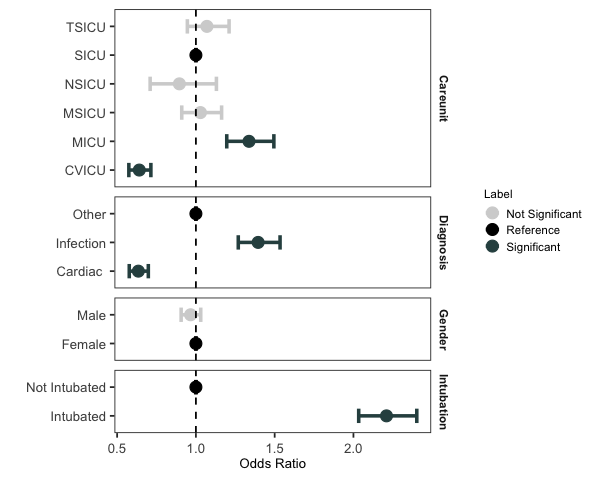

In [799]:
options(repr.plot.width=5, repr.plot.height=4)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [800]:
pdf(file.path(PLOT_DIR, paste0("categoricalmodelodds.pdf")), 5,4)
plot(p)
dev.off()

pdf 
  2

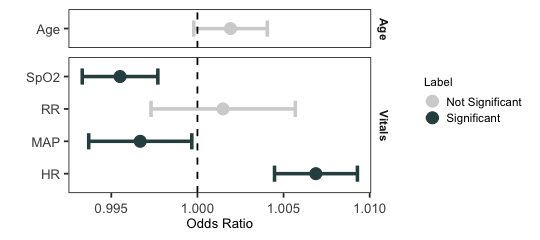

In [801]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [802]:
pdf(file.path(PLOT_DIR, paste0("continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

## Norepinephrine

In [885]:
pressor_choice <- 'Norepinephrine'

In [886]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR), 
           SPO2 = as.numeric(SPO2))

# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

Adding missing grouping variables: `pressor`


In [887]:
dim(model_input_cleaned_df)

[1] 1271   10

In [826]:
model_input_cleaned_df <- model_input_cleaned_df %>% sample_frac(fraction=1)

In [827]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.474117  5        1.039569
intub            1.129838  1        1.062938
simple_diagnosis 1.369660  2        1.081815
age_cohort       1.059196  1        1.029173
gender           1.028327  1        1.014064
MBP              1.022746  1        1.011309
RR               1.176321  1        1.084583
HR               1.151303  1        1.072988
SPO2             1.066115  1        1.032529


Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [828]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6856479,0.02906057,0.7081025,0.004394418


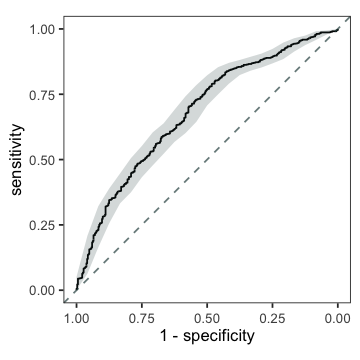

In [829]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [830]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [831]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% select(-MBP, -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2181    97.50 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2264   101.21 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2253   100.71 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2281   102.00 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2273   101.63 |


In [832]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [833]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [834]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...


In [835]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"


In [837]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

In [879]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,0.7579317,0.6460248,0.8874605,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,0.6693776,0.5641998,0.7929475,TRUE,Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,0.7783003,0.5481609,1.1173304,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0804149,0.8847796,1.3199110,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,1.0294313,0.8455778,1.2531149,FALSE,Not Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,3.1480613,2.8365054,3.4946784,TRUE,Significant
8,Categorical,Intubation,,Variable,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,Diagnosis,simple_diagnosisINFECTION,Variable,Infection,1.0248886,0.9180963,1.1446741,FALSE,Not Significant


In [838]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

In [880]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Continuous,Vitals,MBP,Variable,MAP,0.9929853,0.9883777,0.9976451,TRUE,Significant
2,Continuous,Vitals,HR,Variable,HR,1.0056329,1.0019888,1.0093037,TRUE,Significant
3,Continuous,Vitals,RR,Variable,RR,1.0019841,0.9951596,1.0088784,FALSE,Not Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.9978598,0.9882723,1.0073599,FALSE,Not Significant
5,Continuous,Age,age_cohort,Variable,Age,1.0022313,0.9991582,1.0053072,FALSE,Not Significant


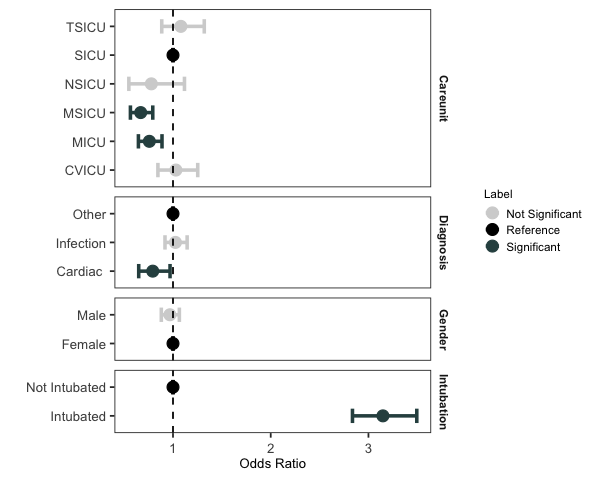

In [839]:
options(repr.plot.width=5, repr.plot.height=4)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [840]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 5,4)
plot(p)
dev.off()

pdf 
  2

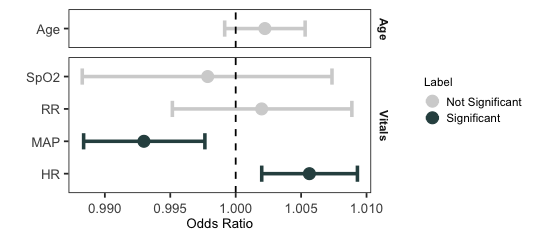

In [841]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [842]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

## Phenylephrine

In [882]:
pressor_choice <- 'Phenylephrine'

In [883]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR), 
           SPO2 = as.numeric(SPO2))

# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

Adding missing grouping variables: `pressor`


In [884]:
dim(model_input_cleaned_df)

[1] 1538   10

In [845]:
model_input_cleaned_df <- model_input_cleaned_df %>% sample_frac(fraction=1)

In [846]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.094613  5        1.076739
intub            1.184109  1        1.088168
simple_diagnosis 1.630860  2        1.130067
age_cohort       1.058409  1        1.028790
gender           1.049583  1        1.024491
MBP              1.030483  1        1.015127
RR               1.303296  1        1.141620
HR               1.277948  1        1.130463
SPO2             1.145812  1        1.070426


Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [847]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7029642,0.01765491,0.6521469,0.004998304


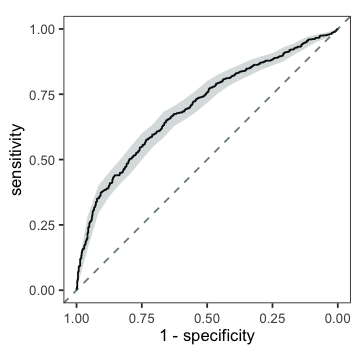

In [848]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [849]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [850]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% select(-MBP, -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2486   100.03 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2576   103.65 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2594   104.35 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2603   104.72 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2594   104.38 |


In [851]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [852]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [853]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...


In [854]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"


In [855]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

In [876]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,2.3621868,1.9875164,2.8126142,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,1.4003690,1.1688033,1.6798921,TRUE,Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,0.9823075,0.7455489,1.2971370,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0612842,0.9157143,1.2301000,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,0.6124580,0.5379056,0.6970462,TRUE,Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,1.7199946,1.5114348,1.9577610,TRUE,Significant
8,Categorical,Intubation,,Variable,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,Diagnosis,simple_diagnosisINFECTION,Variable,Infection,3.1224164,2.5647262,3.8256963,TRUE,Significant


In [856]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

In [877]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,Continuous,Vitals,MBP,Variable,MAP,0.9980424,0.9943761,1.0017188,FALSE,Not Significant
2,Continuous,Vitals,HR,Variable,HR,1.0035842,1.0002117,1.0069861,TRUE,Significant
3,Continuous,Vitals,RR,Variable,RR,1.0030264,0.9975467,1.0085378,FALSE,Not Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.9962400,0.9930980,0.9993803,TRUE,Significant
5,Continuous,Age,age_cohort,Variable,Age,1.0013440,0.9984592,1.0042355,FALSE,Not Significant


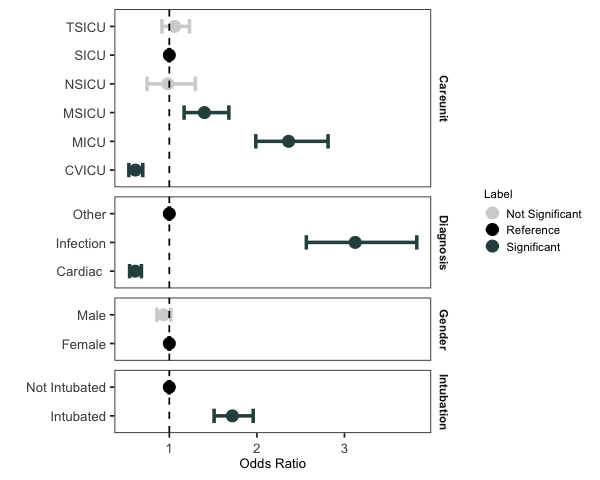

In [857]:
options(repr.plot.width=5, repr.plot.height=4)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [858]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 5,4)
plot(p)
dev.off()

pdf 
  2

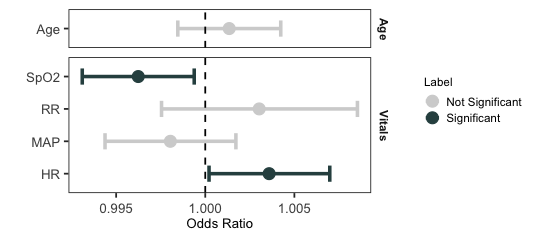

In [859]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [860]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

In [861]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6688474,0.01376877,0.6195833,0.019576683
Norepinephrine,0.6856479,0.02906057,0.7081025,0.004394418
Phenylephrine,0.7029642,0.01765491,0.6521469,0.004998304


In [862]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))

## Dopamine (excluded)

In [888]:
pressor_choice <- 'Dopamine'

In [889]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR), 
           SPO2 = as.numeric(SPO2))

# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

Adding missing grouping variables: `pressor`


In [890]:
dim(model_input_cleaned_df)

[1] 96 10